# AAMC Table B8 Analyzer

### Importing the required libraries

In [89]:
import re
import pandas as pd
import numpy as np
import math
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

### Importing all the info from the merged excel doc 

In [90]:
b8_2016 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2016-2017')
b8_2017 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2017-2018')
b8_2018 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2018-2019')
b8_2019 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2019-2020')
b8_2020 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2020-2021')
b8_2021 = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='2021-2022')

b8_2016['Matriculation_Year'] = 2016
b8_2017['Matriculation_Year'] = 2017
b8_2018['Matriculation_Year'] = 2018
b8_2019['Matriculation_Year'] = 2019
b8_2020['Matriculation_Year'] = 2020
b8_2021['Matriculation_Year'] = 2021

b8 = pd.concat([b8_2016, b8_2017, b8_2018, b8_2019, b8_2020, b8_2021], axis=0)
b8 = b8.sort_values(by=['MD-PhD Programs', 'Matriculation_Year']).reset_index(drop=True)
b8

,State,MD-PhD Programs,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year
0,AL,Alabama,260,5.4,94.6,45.4,54.6,8,0.0,100.0,50.0,50.0,2016
1,AL,Alabama,283,4.9,95.1,45.6,54.4,9,22.2,77.8,44.4,55.6,2017
2,AL,Alabama,302,6.0,94.0,42.7,57.0,8,25.0,75.0,37.5,62.5,2018
3,AL,Alabama,245,4.1,95.9,49.0,51.0,8,0.0,100.0,62.5,37.5,2019
4,AL,Alabama,235,5.5,94.5,50.6,49.4,10,0.0,100.0,60.0,40.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...
901,CT,Yale,753,3.3,96.7,45.6,54.2,19,5.3,94.7,42.1,57.9,2021
902,NY,Zucker Hofstra Northwell,81,33.3,66.7,49.4,50.6,4,25.0,75.0,25.0,75.0,2018
903,NY,Zucker Hofstra Northwell,87,28.7,71.3,43.7,56.3,4,75.0,25.0,50.0,50.0,2019
904,NY,Zucker Hofstra Northwell,110,32.7,67.3,49.1,50.9,3,66.7,33.3,33.3,66.7,2020


### Calculating cycle totals and plotting them

In [91]:
cycle_totals = b8.groupby('Matriculation_Year').sum().reset_index()
cycle_totals = cycle_totals[["Matriculation_Year", "Applications", "Matriculants"]]
cycle_totals

,Matriculation_Year,Applications,Matriculants
0,2016,26232,649
1,2017,24664,646
2,2018,25794,672
3,2019,26529,708
4,2020,28327,701
5,2021,33288,750


In [92]:
totals = pd.read_excel('AAMC Table B-8 Merged.xlsx', sheet_name='Totals')
totals["Matriculation Year"] = [2016, 2017, 2018, 2019, 2020, 2021]
totals = pd.melt(totals, id_vars="Matriculation Year", value_vars=["Total Applicants", "Matriculants"])
totals.columns = ["Matriculation Year", "Status", "Number"]
totals

,Matriculation Year,Status,Number
0,2016,Total Applicants,1936
1,2017,Total Applicants,1858
2,2018,Total Applicants,1855
3,2019,Total Applicants,1813
4,2020,Total Applicants,1855
5,2021,Total Applicants,2091
6,2016,Matriculants,649
7,2017,Matriculants,646
8,2018,Matriculants,672
9,2019,Matriculants,708


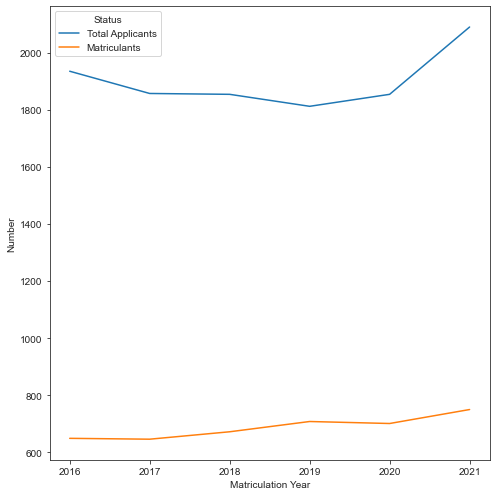

In [93]:
fig, ax = plt.subplots(figsize=(7,7))

sns.lineplot(data=totals, x="Matriculation Year", y="Number", hue="Status", markers="o")

plt.tight_layout()
plt.show()

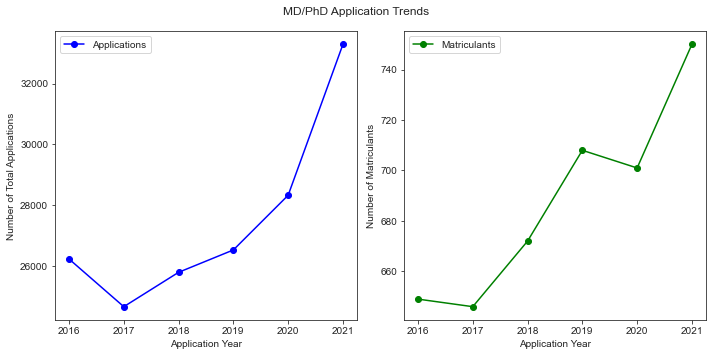

In [94]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,5), ncols=2)

ax[0].plot(cycle_totals["Matriculation_Year"], cycle_totals["Applications"], marker="o", color="blue", label="Applications")
ax[1].plot(cycle_totals["Matriculation_Year"], cycle_totals["Matriculants"], marker="o", color="green", label="Matriculants")

ax[0].set(xlabel="Application Year", ylabel="Number of Total Applications")
ax[1].set(xlabel="Application Year", ylabel="Number of Matriculants")

ax[0].legend()
ax[1].legend()

plt.suptitle("MD/PhD Application Trends")

plt.tight_layout()
plt.show()

#plt.savefig("Applications_Matriculations.png")

## Filtering out all small schools and calculating the percent change, cycle to cycle

In [95]:
# Filtering out programs with less than an average of 5 matriculants for 2016-2021
b8_means = b8.groupby('MD-PhD Programs').mean().reset_index() #mean calculations
big_schools = list(b8_means[b8_means['Matriculants'] >= 4]['MD-PhD Programs']) #listing with > 4 matriculants

school_filter = ["Alabama", "Arizona", "Baylor", "Boston", "Case Western Reserve", "Chicago-Pritzker", "Cincinnati", "Colorado", "Columbia-Vagelos", "Connecticut", "Cornell-Weill", "Duke", "Einstein", "Emory", "Florida", "Georgetown", "Harvard", "Illinois",
                 "Indiana", "Iowa-Carver", "Jefferson-Kimmel", "Johns Hopkins", "Kansas", "LSU New Orleans", "MC Wisconsin", "MU South Carolina", "Maryland", "Massachusetts", "Mayo-Alix", "Miami-Miller", "Michigan", "Minnesota", "Mount Sinai-Icahn", 
                 "NYU-Grossman", "Nebraska", "North Carolina", "Northwestern-Feinberg", "Ohio State", "Oregon", "Penn State", "Pennsylvania-Perelman", "Pittsburgh", "Renaissance Stony Brook", "Rochester", "Rutgers New Jersey", "Rutgers-RW Johnson",
                 "Southern Cal-Keck", "Stanford", "Texas A & M", "Tufts", "U Washington", "UC Irvine", "UC San Diego", "UC San Francisco", "UCLA-Geffen", "UT Houston-McGovern", "UT Medical Branch", "UT San Antonio-Long", "UT Southwestern", "Utah", "Vanderbilt",
                 "Virginia", "Virginia Commonwealth", "Washington U St Louis", "Wayne State", "Wisconsin", "Yale"]  #manual filter

print("Number of schools in big_schools:", len(big_schools), "\nNumber of schools in school_filter:", len(school_filter))

Number of schools in big_schools: 67 
Number of schools in school_filter: 67


In [96]:
# Filtering out small schools, keeping only big schools and sorting alphabetically by school name
b8_16 = b8_2016[b8_2016["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_17 = b8_2017[b8_2017["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_18 = b8_2018[b8_2018["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_19 = b8_2019[b8_2019["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_20 = b8_2020[b8_2020["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_21 = b8_2021[b8_2021["MD-PhD Programs"].isin(school_filter)].sort_values(by='MD-PhD Programs').reset_index(drop=True)
b8_16

,State,MD-PhD Programs,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year
0,AL,Alabama,260,5.4,94.6,45.4,54.6,8,0.0,100.0,50.0,50.0,2016
1,AZ,Arizona,115,14.8,85.2,48.7,51.3,0,0.0,0.0,0.0,0.0,2016
2,TX,Baylor,427,17.3,82.7,38.9,60.7,12,33.3,66.7,33.3,66.7,2016
3,MA,Boston,443,9.3,90.7,40.6,58.9,4,0.0,100.0,50.0,50.0,2016
4,OH,Case Western Reserve,398,8.0,92.0,38.7,61.1,14,7.1,92.9,28.6,71.4,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,VA,Virginia Commonwealth,151,13.9,86.1,45.0,54.3,5,20.0,80.0,0.0,100.0,2016
63,MO,Washington U St Louis,535,2.1,97.9,37.0,62.6,26,0.0,100.0,46.2,53.8,2016
64,MI,Wayne State,72,43.1,56.9,38.9,61.1,3,33.3,66.7,66.7,33.3,2016
65,WI,Wisconsin,326,6.7,93.3,40.2,59.2,11,0.0,100.0,45.5,54.5,2016


In [97]:
# Getting the baseline number of applications from 2016 and defining a function to calculate percent change relative to 2016
baseline = np.array(b8_16["Applications"])

def delta_n(df):
    """Calculates change in number between a new cycle's applications compared to a baseline's number of applications"""
    delta = df["Applications"] - baseline
    return(delta)

def percent_change(df):
    """Calculates percent change between a new cycle's applications compared to a baseline's number of applications"""
    per_change = (df["Applications"] - baseline) / (baseline) * 100
    return(per_change)

baseline

array([260, 115, 427, 443, 398, 530, 189, 396, 688, 135, 581, 615, 419,
       598, 168, 281, 714, 385, 232, 198, 193, 673, 100,  70, 159, 201,
       317, 255, 282, 184, 436, 279, 456, 468,  85, 443, 550, 225, 301,
       212, 634, 431, 251, 248, 101, 182, 279, 691, 118, 385, 583, 319,
       492, 645, 531, 199, 116, 180, 312,  95, 557, 301, 151, 535,  72,
       326, 546], dtype=int64)

In [98]:
# Calculating percent change for each application year, relative to 2016, for each individual school (which are already sorted & filtered)
for year in [b8_16, b8_17, b8_18, b8_19, b8_20, b8_21]:
    year["new_applicants"] = delta_n(df=year)
    year["percent_change"] = percent_change(df=year)

# Combining all individual dfs into one and sorting
b8_filt = pd.concat([b8_16, b8_17, b8_18, b8_19, b8_20, b8_21], axis=0)
b8_filt = b8_filt.replace(0, np.nan)
b8_filt['Applicant Matriculant Ratio'] = b8_filt['Applications'] / b8_filt['Matriculants']  #applicant:matriculant ratios
b8_filt = b8_filt.sort_values(by=['Matriculation_Year', 'MD-PhD Programs']).reset_index(drop=True)
display(b8_filt.shape)
display(b8_filt.head())

# Finding the mean and standard deviation for each big school and sorting
b8_filt_means = b8_filt.groupby('MD-PhD Programs').mean().sort_values(by='Applicant Matriculant Ratio').reset_index()
b8_filt_means.columns = [col + " mean" for col in b8_filt_means.columns]
b8_filt_means = b8_filt_means.rename(columns={"MD-PhD Programs mean": "MD-PhD Programs"})

b8_filt_std = b8_filt.groupby('MD-PhD Programs').std().sort_values(by='Applicant Matriculant Ratio').reset_index()
b8_filt_std.columns = [col + " std" for col in b8_filt_std.columns]
b8_filt_std = b8_filt_std.rename(columns={"MD-PhD Programs std": "MD-PhD Programs"})

b8_filt_agg = b8_filt_means.merge(b8_filt_std, on="MD-PhD Programs").sort_values(by='Applicant Matriculant Ratio mean').reset_index(drop=True)
display(b8_filt_agg.shape)
display(b8_filt_agg.tail())

# Optionally exporting to excel
#b8_filt.to_excel("table b8 filtered.xlsx", index=False)

(402, 16)

,State,MD-PhD Programs,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year,new_applicants,percent_change,Applicant Matriculant Ratio
0,AL,Alabama,260,5.4,94.6,45.4,54.6,8.0,NaN,100.0,50.0,50.0,2016,NaN,NaN,32.500000
1,AZ,Arizona,115,14.8,85.2,48.7,51.3,NaN,NaN,NaN,NaN,NaN,2016,NaN,NaN,NaN
2,TX,Baylor,427,17.3,82.7,38.9,60.7,12.0,33.3,66.7,33.3,66.7,2016,NaN,NaN,35.583333
3,MA,Boston,443,9.3,90.7,40.6,58.9,4.0,NaN,100.0,50.0,50.0,2016,NaN,NaN,110.750000
4,OH,Case Western Reserve,398,8.0,92.0,38.7,61.1,14.0,7.1,92.9,28.6,71.4,2016,NaN,NaN,28.428571


(67, 29)

,MD-PhD Programs,Applications mean,in state applicants mean,out of state applicants mean,women applicants mean,men applicants mean,Matriculants mean,in state matriculants mean,out of state matriculants mean,women matriculants mean,...,men applicants std,Matriculants std,in state matriculants std,out of state matriculants std,women matriculants std,men matriculants std,Matriculation_Year std,new_applicants std,percent_change std,Applicant Matriculant Ratio std
62,Georgetown,305.166667,0.933333,99.066667,48.666667,51.116667,4.333333,NaN,100.000000,32.500000,...,2.868740,0.816497,NaN,0.000000,15.000000,20.412415,1.870829,28.930952,10.295713,15.655229
63,Boston,415.000000,10.183333,89.816667,46.100000,53.816667,5.666667,16.700000,88.866667,47.233333,...,2.960687,0.816497,0.000000,8.623843,19.491708,19.491708,1.870829,49.967990,11.279456,18.888152
64,Stanford,674.166667,22.616667,77.383333,41.566667,58.300000,9.000000,49.420000,58.816667,54.516667,...,3.435695,1.264911,15.400714,24.429524,19.042838,19.042838,1.870829,83.181729,12.037877,9.887362
65,Southern Cal-Keck,318.166667,40.216667,59.783333,45.000000,54.933333,4.000000,83.333333,33.333333,50.660000,...,3.588129,1.264911,19.663842,11.547005,27.734058,17.383268,1.870829,50.244403,18.008746,30.299879
66,Tufts,414.166667,12.233333,87.766667,48.333333,51.600000,4.500000,30.520000,74.566667,51.050000,...,2.635147,1.516575,17.895726,20.284247,17.897346,17.897346,1.870829,68.348372,17.752824,44.678133


## Plotting Stuff

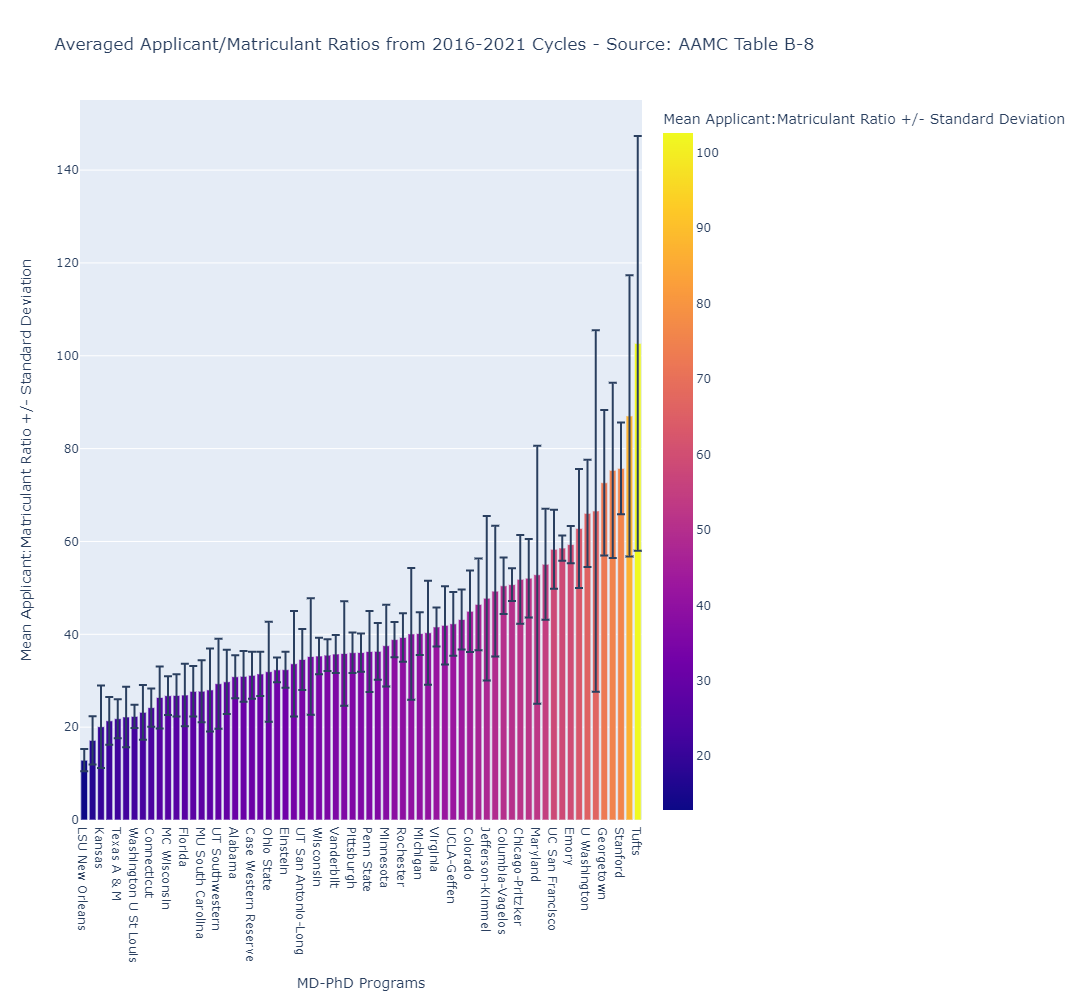

In [99]:
# Using plotly to graph matriculant/applicant ratios and other info
fig = px.bar(b8_filt_agg, x='MD-PhD Programs', y='Applicant Matriculant Ratio mean', error_y='Applicant Matriculant Ratio std',
            color='Applicant Matriculant Ratio mean', width=2000, height=1000,
            hover_data=['Applications mean', 'Matriculants mean', 'women matriculants mean', 'out of state matriculants mean'],
            title="Averaged Applicant/Matriculant Ratios from 2016-2021 Cycles - Source: AAMC Table B-8",
            labels={'Applicant Matriculant Ratio mean': 'Mean Applicant:Matriculant Ratio +/- Standard Deviation'})
fig.show()
#fig.write_html('Matriculant Applicant Ratios.html')

In [100]:
# Plotting a Choropleth Geographical map of the US for each state after filtering out 2016 data (baseline) because it's percent change is 0
# Use data from 2021, compared to 2020 - otherwise the "Fauci effect" will be inaccurate 
b8_filt_2 = b8_filt[b8_filt["Matriculation_Year"] > 2020]
b8_filt_means2 = b8_filt_2.groupby('State').mean().sort_values(by='percent_change', ascending=False).reset_index()
b8_filt_means2.head()

,State,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year,new_applicants,percent_change,Applicant Matriculant Ratio
0,UT,186.0,10.80,89.20,43.50,55.90,8.0,25.00,75.00,37.5,62.50,2021.0,91.0,95.789474,23.250000
1,NJ,217.0,14.95,85.05,47.45,52.25,4.5,42.50,57.50,57.5,42.50,2021.0,75.5,57.787510,49.875000
2,MI,356.5,9.75,90.25,46.55,53.00,11.0,20.85,79.15,36.5,63.55,2021.0,102.5,56.555810,29.000000
3,OR,465.0,6.00,94.00,51.40,48.20,8.0,NaN,100.00,62.5,37.50,2021.0,164.0,54.485050,58.125000
4,CT,488.5,6.55,93.45,47.60,52.30,13.5,8.90,91.10,52.3,47.70,2021.0,148.0,51.919007,33.815789


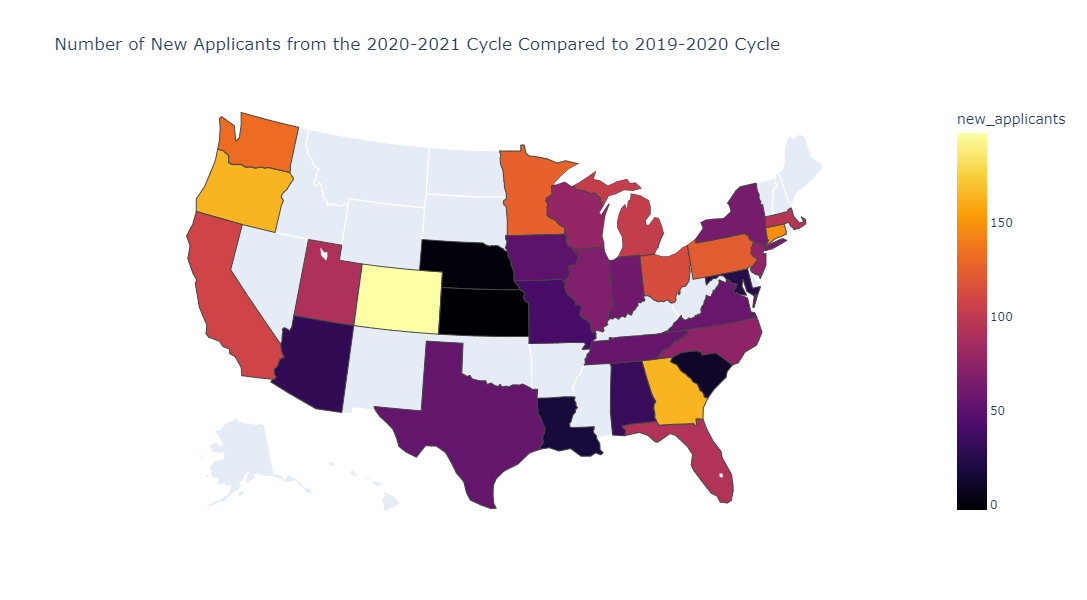

In [121]:
fig = px.choropleth(data_frame=b8_filt_means2,
                    locations="State",
                    color="new_applicants",
                    locationmode='USA-states',
                    scope='usa',
                    color_continuous_scale="Inferno",
                    width=1000, height=600,
                    title="Number of New Applicants from the 2020-2021 Cycle Compared to 2019-2020 Cycle")
fig.show()
#fig.write_html('Choropleth New Applicants.html')

In [102]:
# Filtering out 2016 (baseline) because it's percent change will be zeros 
b8_filt_3 = b8_filt[b8_filt["Matriculation_Year"] > 2016]
b8_filt_means3 = b8_filt_3.groupby('MD-PhD Programs').mean().sort_values(by='percent_change').reset_index()
b8_filt_means3.head()

,MD-PhD Programs,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year,new_applicants,percent_change,Applicant Matriculant Ratio
0,Kansas,80.4,13.52,86.48,45.94,54.08,5.0,49.050000,60.76,36.94,63.06,2019.0,-19.6,-19.600000,17.432381
1,Illinois,311.8,13.78,86.22,48.96,50.98,13.0,24.000000,76.00,53.88,46.12,2019.0,-73.2,-19.012987,25.065960
2,Vanderbilt,502.6,3.00,97.00,46.76,53.16,14.6,8.600000,93.14,50.86,49.16,2019.0,-54.4,-9.766607,34.330952
3,Johns Hopkins,607.8,7.22,92.78,43.50,56.34,11.4,21.425000,82.86,40.06,59.94,2019.0,-65.2,-9.687964,67.648485
4,Jefferson-Kimmel,177.6,15.42,84.58,50.58,49.34,4.4,33.333333,80.00,57.50,54.00,2019.0,-15.4,-7.979275,44.460000


In [103]:
b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[b8_filt_means3["percent_change"] > 15]["MD-PhD Programs"])), "Growth"] = "Rapid Up"
b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[(b8_filt_means3["percent_change"] < 15) & (b8_filt_means3["percent_change"] > 5)]["MD-PhD Programs"])), "Growth"] = "Up"
#b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[(b8_filt_means3["percent_change"] < 15) & (b8_filt_means3["percent_change"] > 10)]["MD-PhD Programs"])), "Growth"] = "Moderate Up"
#b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[(b8_filt_means3["percent_change"] < 10) & (b8_filt_means3["percent_change"] > 5)]["MD-PhD Programs"])), "Growth"] = "Slow Up"
#b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[(b8_filt_means3["percent_change"] < 5) & (b8_filt_means3["percent_change"] > 0)]["MD-PhD Programs"])), "Growth"] = "Steady"
b8_filt.loc[b8_filt["MD-PhD Programs"].isin(list(b8_filt_means3[b8_filt_means3["percent_change"] < 5]["MD-PhD Programs"])), "Growth"] = "Steady"
#b8_filt['Growth'] = pd.Categorical(b8_filt['Growth'], categories=["Steady", "Up", "Rapid Up"])
b8_filt.head()

,State,MD-PhD Programs,Applications,in state applicants,out of state applicants,women applicants,men applicants,Matriculants,in state matriculants,out of state matriculants,women matriculants,men matriculants,Matriculation_Year,new_applicants,percent_change,Applicant Matriculant Ratio,Growth
0,AL,Alabama,260,5.4,94.6,45.4,54.6,8.0,NaN,100.0,50.0,50.0,2016,NaN,NaN,32.500000,Steady
1,AZ,Arizona,115,14.8,85.2,48.7,51.3,NaN,NaN,NaN,NaN,NaN,2016,NaN,NaN,NaN,Rapid Up
2,TX,Baylor,427,17.3,82.7,38.9,60.7,12.0,33.3,66.7,33.3,66.7,2016,NaN,NaN,35.583333,Steady
3,MA,Boston,443,9.3,90.7,40.6,58.9,4.0,NaN,100.0,50.0,50.0,2016,NaN,NaN,110.750000,Steady
4,OH,Case Western Reserve,398,8.0,92.0,38.7,61.1,14.0,7.1,92.9,28.6,71.4,2016,NaN,NaN,28.428571,Up


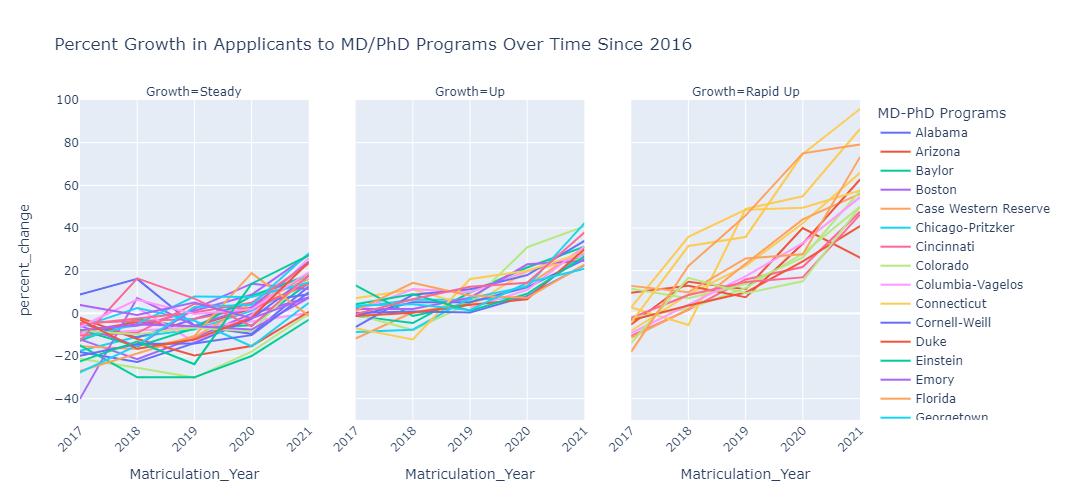

In [128]:
fig = px.line(data_frame=b8_filt, x='Matriculation_Year', y='percent_change',
              range_x=[2017, 2021],
              range_y=[-50, 100],
              line_group='MD-PhD Programs',
              color='MD-PhD Programs',
              facet_col='Growth',
              facet_col_spacing=0.06,
              category_orders={'Growth': ["Steady", "Up", "Rapid Up"]},
             width=1400, height=500,
             title="Percent Growth in Appplicants to MD/PhD Programs Over Time Since 2016")
fig.update_xaxes(tickangle=315)
fig.show()
#fig.write_html('Percent Growth of Applicants Over Time.html')

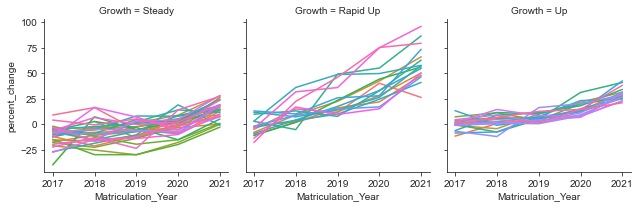

In [52]:
%matplotlib inline
sns.set_style('ticks')
#plt.figure(figsize=(20, 10))

g = sns.FacetGrid(data=b8_filt, col="Growth", hue='MD-PhD Programs')
g.map(sns.lineplot, 'Matriculation_Year', 'percent_change')

#plt.legend()
plt.tight_layout()

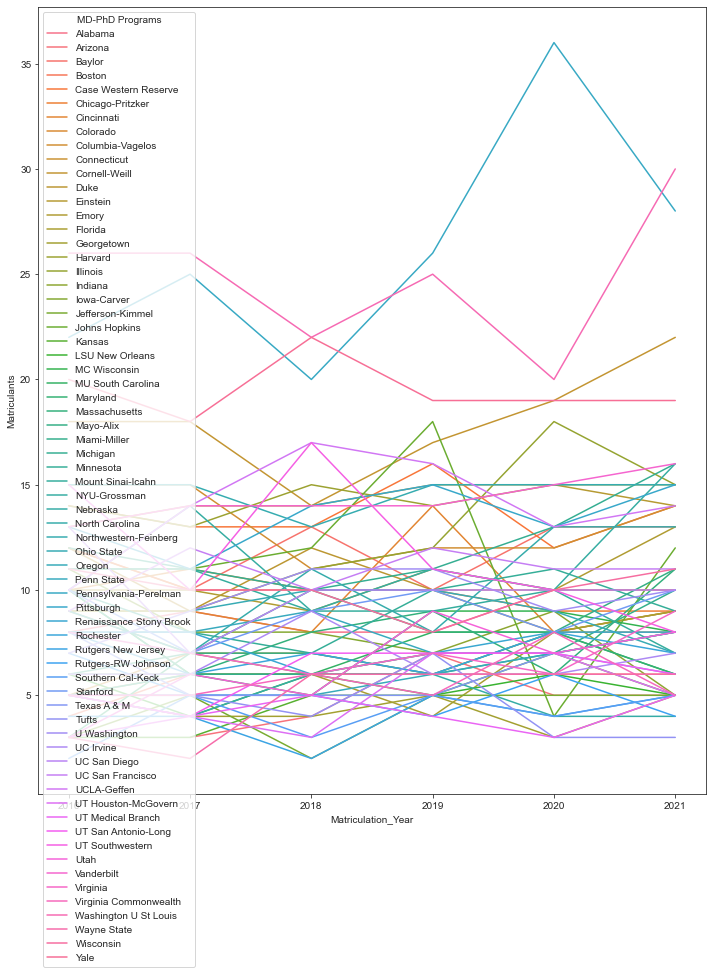

In [126]:
%matplotlib inline
sns.set_style('ticks')
plt.figure(figsize=(10, 14))
line = sns.lineplot(data=b8_filt, x='Matriculation_Year', y='Matriculants', hue='MD-PhD Programs')
plt.tight_layout()